<a href="https://colab.research.google.com/github/srigouri/CE888-Assignment1/blob/main/2101259_Causal_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CAUSAL INFERENCE ON IHDP AND JOBS DATASET 
-------------------

My assignment is to train a machine learning model for which causality remains a hurdle.Making predictions and dealing with unfamiliar events is difficult when there is a lack of causal knowledge.Causality can help machine learning's inability to generalise.Here the task is divided into 2 parts.
Part-1 deals with IHDP dataset and 
Part-2 deals with Jobs dataset.

#Step-1 Loading required packages:

In [26]:
!pip install econml

In [27]:
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import dowhy
from dowhy import CausalModel

# **PART-1**

---
# Step-2  Average Effect:



# 1.Problem Setting

Part-1: To estimate the casual effects of how the family support (treatment) effects the cognitive test score for the child (outcome).


#2.Metrics

These are the two functions used to calculate Absolute error for the Average Treatment Effect (ATE) and Precision in Estimating the Heterogeneous Treatment Effect (PEHE) using two arguments true treatment effect value(effect_true) and predicted treatment effect value(effect_pred).

In [28]:
def abs_ate(effect_true, effect_pred):
  return np.abs((np.mean(effect_true)-(np.mean(effect_pred))))

def pehe(effect_true, effect_pred):
  return np.sqrt(np.mean(np.square((effect_true - effect_pred))))

Loading IHDP Dataset:

In [29]:
ihdp_data=pd.read_csv('https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/ihdp.csv')
ihdp_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,t,yf,ycf,ite
0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.771232,-0.298509,4.657928
1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.956273,5.783770,3.428604
2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.164164,7.055789,3.658195
3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.172307,1.379697,4.585505
4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.834469,2.747986,4.265591


In [30]:
ihdp_data.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,t,yf,ycf,ite
count,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,3.626431e-17,2.348263e-17,-4.666801e-17,-9.012574e-16,4.518177e-17,-7.251376e-16,0.514056,0.093708,0.520750,0.364123,0.269076,0.219545,0.358768,0.463186,0.140562,0.959839,0.594378,0.963855,0.135207,0.135207,0.156627,0.081660,0.073628,0.128514,0.157965,0.186078,3.159538,5.696107,4.016067
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.500137,0.291618,0.499904,0.481506,0.443777,0.414216,0.479960,0.498977,0.347802,0.196467,0.491341,0.186775,0.342174,0.342174,0.363692,0.274029,0.261339,0.334886,0.364953,0.389430,2.179956,1.980121,0.859736
min,-2.731287e+00,-3.800823e+00,-1.850350e+00,-8.796060e-01,-5.130428e+00,-1.851480e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.543902,-1.037628,-1.866989
25%,-6.669461e-01,-6.027100e-01,-7.332610e-01,-8.796060e-01,-5.666720e-01,-8.577868e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.626779,5.053598,3.775936
50%,1.652752e-01,1.968181e-01,-3.608980e-01,1.617025e-01,1.210172e-01,-2.970882e-02,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.577294,6.209686,4.304433
75%,8.137593e-01,5.965822e-01,7.561910e-01,1.617025e-01,6.836721e-01,6.327536e-01,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.494637,6.948922,4.569454
max,1.505476e+00,2.595403e+00,2.990369e+00,2.244320e+00,2.371637e+00,2.951372e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.268228,10.171004,4.670125


In the above scenario,yf are outcomes observed with the treatment(t) i.e family support is given(t=1), no family support(t=0).ycf(counterfactuals) are the outcomes that would have been observed had the treatment been different.

In [31]:
ihdp_data.isnull().sum()

x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
x14    0
x15    0
x16    0
x17    0
x18    0
x19    0
x20    0
x21    0
x22    0
x23    0
x24    0
x25    0
t      0
yf     0
ycf    0
ite    0
dtype: int64

In [32]:
X=ihdp_data[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25']]
T=ihdp_data['t']
Y=ihdp_data[['yf','ycf']]
ite=ihdp_data['ite']

In [33]:
Y.describe()

,yf,ycf
count,747.000000,747.000000
mean,3.159538,5.696107
std,2.179956,1.980121
min,-1.543902,-1.037628
25%,1.626779,5.053598
50%,2.577294,6.209686
75%,4.494637,6.948922
max,11.268228,10.171004


In [34]:
T.value_counts()

0.0    608
1.0    139
Name: t, dtype: int64

Applying Principal Component Analysis(PCA) for dimensionality reduction of X which has got 25 features as inputs

#Data Pre-processing:

In [35]:
x_train, x_test, t_train, t_test, y_train, y_test, ite_train, ite_test = train_test_split(X, T, Y, ite, test_size=0.2)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

**Treatment Effect:**        

The Average Treatment Effect (ATE) builds on ITE:
AT E = E[ITE]
Note: empirical (sample) ATE is the mean of ITEs

In [36]:
ATE=np.mean(ite)
ATE

#LINEAR REGRESSION

Description:


With Linear Regression model I will estimate P(Y|X,T) , that is, we regress Y on X and T. Once trained, the model predicts potential outcomes  y^(i)t . Thus, to obtain ITE predictions for each individual, we need to predict both  yf^  and  ycf^ , that is, predict the outcomes for both factual and counterfactual treatments for each individual.

By calculating the difference between the factual and counterfactual outcome, we can obtain the effect per given individual. In other words:

ITEˆ(i)=yf^−ycf^

We will merge both X columns and Treatment column and build a model to make predictions on outcome.then compute ATE^ by taking average of sum of ITE^ which is obtained by diffecences of yf^ and ycf^ from test data.

Applying Principal Component Analysis(PCA) for dimensionality reduction of X which has got 25 features as inputs



In [37]:
pca = PCA()
pca.fit(X)

PCA()

In [38]:
pca.explained_variance_ratio_

array([0.28846764, 0.16068443, 0.12091722, 0.10756642, 0.03655703,
       0.03477248, 0.02955641, 0.02555713, 0.02419276, 0.0210092 ,
       0.02045709, 0.01883792, 0.01512188, 0.01387969, 0.0134508 ,
       0.01227229, 0.01169198, 0.00945866, 0.00875866, 0.0077226 ,
       0.00696545, 0.00377168, 0.00359057, 0.00309412, 0.00164588])

Text(0, 0.5, 'Cumulative Explained variance')

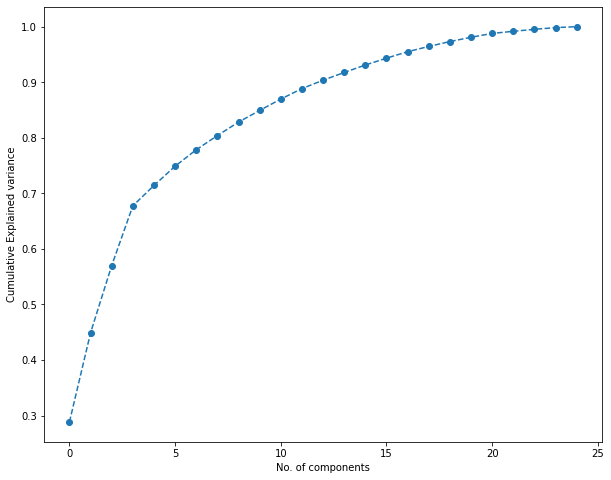

In [39]:
from matplotlib import markers
plt.figure(figsize=(10,8))
plt.plot(pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.xlabel('No. of components')
plt.ylabel('Cumulative Explained variance')

In [50]:
pca1 = PCA(n_components=7)
X_pca=pca1.fit(X)


#Evaluation

econml.dr.LinearDRLearner() is the CATE Estimator I am planning to use for double robustness and evaluate my predictions using metrics functions Abs_ate and pehe functions.

To clean up residual covariate imbalance,regression adjustment like "double robustness" is used.

Function to compute sample weights.



In [41]:
def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  ptx = clf.predict_proba(x).T[1].T + 0.0001
  wi = ((ti/ptx)+((1-ti)/(1-ptx))) 
  return wi

#PART-2



---------------------------------------------------------------------------------------------------------



#1.Problem Setting


Loading Jobs Dataset:

The Jobs dataset is a combination of the experiment done by as part of the National
Supported Work Program (NSWP) and observational data from the Panel Study of Income Dynamics (PSID)

In [42]:
Jobs_data=pd.read_csv('https://raw.githubusercontent.com/dmachlanski/CE888_2022/main/project/data/jobs.csv')
Jobs_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,t,y,e
0,-0.614282,1.464727,0.0,0.0,1.0,0.0,2.393250,2.746196,-0.653311,-0.656913,1.627531,2.462337,2.937244,0.0,0.0,2.843909,0.0,0.0,1.0,0.0
1,-0.802463,0.101835,0.0,0.0,1.0,0.0,0.109885,0.498271,-0.785284,-0.743407,-0.022502,-0.177193,0.082537,0.0,0.0,0.038422,0.0,0.0,1.0,0.0
2,-0.896553,-0.238888,1.0,0.0,1.0,1.0,-0.085212,-0.148097,-0.847312,-0.781606,-0.361348,-0.286221,-0.303615,0.0,0.0,-0.191304,0.0,0.0,1.0,0.0
3,-0.896553,-0.238888,0.0,0.0,0.0,1.0,0.405581,0.325594,-0.847312,-0.781606,-0.361348,0.023020,-0.039630,0.0,0.0,0.173108,0.0,0.0,1.0,1.0
4,0.138440,-1.601779,1.0,0.0,1.0,1.0,-0.722531,-0.212734,-0.019840,-0.156019,-1.422084,-0.514563,-0.331552,0.0,0.0,-0.779227,0.0,0.0,1.0,0.0


In [43]:
Jobs_data.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,t,y,e
count,3.212000e+03,3.212000e+03,3212.000000,3212.000000,3212.000000,3212.000000,3.212000e+03,3.212000e+03,3.212000e+03,3.212000e+03,3.212000e+03,3.212000e+03,3.212000e+03,3212.000000,3212.000000,3.212000e+03,3212.000000,3212.000000,3212.000000,3212.000000
mean,2.382901e-16,-3.820971e-16,0.374222,0.048879,0.707970,0.411893,-1.200783e-16,4.956600e-17,-6.083414e-18,1.757408e-14,-2.638422e-16,-1.168292e-17,9.429291e-17,0.168742,0.167497,1.901758e-16,0.010897,0.092466,0.849938,0.224782
std,1.000000e+00,1.000000e+00,0.483997,0.215649,0.454767,0.492253,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.374582,0.373477,1.000000e+00,0.103833,0.289727,0.357188,0.417504
min,-1.461095e+00,-3.986840e+00,0.000000,0.000000,0.000000,0.000000,-1.147411e+00,-1.110467e+00,-1.164047e+00,-9.488316e-01,-2.143974e+00,-5.580568e-01,-5.188151e-01,0.000000,0.000000,-9.799811e-01,0.000000,0.000000,0.000000,0.000000
25%,-8.024627e-01,-5.796108e-01,0.000000,0.000000,0.000000,0.000000,-8.923385e-01,-9.139141e-01,-7.852843e-01,-7.434072e-01,-6.707297e-01,-5.423814e-01,-5.098380e-01,0.000000,0.000000,-8.142367e-01,0.000000,0.000000,1.000000,0.000000
50%,-3.320111e-01,1.018350e-01,0.000000,0.000000,1.000000,0.000000,-8.521244e-02,-8.346011e-02,-4.355556e-01,-4.998533e-01,-2.250229e-02,-2.862214e-01,-2.737369e-01,0.000000,0.000000,-2.035020e-01,0.000000,0.000000,1.000000,0.000000
75%,7.970728e-01,4.425579e-01,1.000000,0.000000,1.000000,1.000000,5.506613e-01,5.629081e-01,6.730184e-01,5.267384e-01,3.458087e-01,1.366588e-01,1.318304e-01,0.000000,0.000000,4.539777e-01,0.000000,0.000000,1.000000,0.000000
max,2.114337e+00,1.805449e+00,1.000000,1.000000,1.000000,1.000000,8.751987e+00,1.016507e+01,2.446737e+00,2.773336e+00,2.113702e+00,2.305284e+01,2.902264e+01,1.000000,1.000000,7.136030e+00,1.000000,1.000000,1.000000,1.000000


Checking the outcomes for how many had undergone NSWP training and has got job placement.


In [44]:
Jobs_data['y'].value_counts()

1.0    2730
0.0     482
Name: y, dtype: int64

Checking for any null values in data.

In [45]:
Jobs_data.isnull().sum()

x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
x14    0
x15    0
x16    0
x17    0
t      0
y      0
e      0
dtype: int64

In [46]:
X_jobs=Jobs_data[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17']]
T_jobs=Jobs_data['t']
Y_jobs=Jobs_data['y']
e_jobs=Jobs_data['e']

In [47]:
e_jobs.value_counts()

0.0    2490
1.0     722
Name: e, dtype: int64

In [48]:
limit = 100
plt.scatter(X_jobs[T == 1][:limit], Y_jobs[T == 1][:limit], c = "r", label = "with Family support")
plt.scatter(X_jobs[T == 0][:limit], Y_jobs[T == 0][:limit], c = "g", label = "No family support")
plt.legend(ncol=1)
plt.savefig('ihdp_scatter.png',dpi=1200)

Boolean Series key will be reindexed to match DataFrame index.


IndexingError: ignored

#Data Pre-processing:

In [ ]:
X_jobs_train, X_jobs_test, T_jobs_train, T_jobs_test, Y_jobs_train, Y_jobs_test, e_jobs_train, e_jobs_test = train_test_split(X_jobs, T_jobs, Y_jobs, e_jobs, test_size=0.2)

scaler_x = StandardScaler()
X_jobs_train = scaler_x.fit_transform(X_jobs_train)
X_jobs_test = scaler_x.transform(X_jobs_test)